In [2]:
# reading in the data
import pandas as pd
import numpy as np
import matplotlib

data_offers = pd.read_csv("../data/data_offers.csv")
data_orders = pd.read_csv("../data/data_orders.csv")

In [3]:
df = data_orders.merge(right = data_offers, how = "inner", on = "order_gk")  # merging the tables on ordergk (order number)

In [4]:
# assigning each key a value
df["is_driver_assigned"] = np.where(df["is_driver_assigned_key"] == 1, "Yes", "No") 
df["order_status"] = np.where(df["order_status_key"] == 4, "Client Cancelled", "System Reject")
df.drop(columns=["is_driver_assigned_key", "order_status_key"], inplace=True)

In [5]:
# an easy way to visualize the combinations of outcomes for these two columns
df.groupby(["is_driver_assigned", "order_status"])["order_gk"].count()

is_driver_assigned  order_status    
No                  Client Cancelled    13435
                    System Reject        9469
Yes                 Client Cancelled     8360
                    System Reject           4
Name: order_gk, dtype: int64

<Axes: >

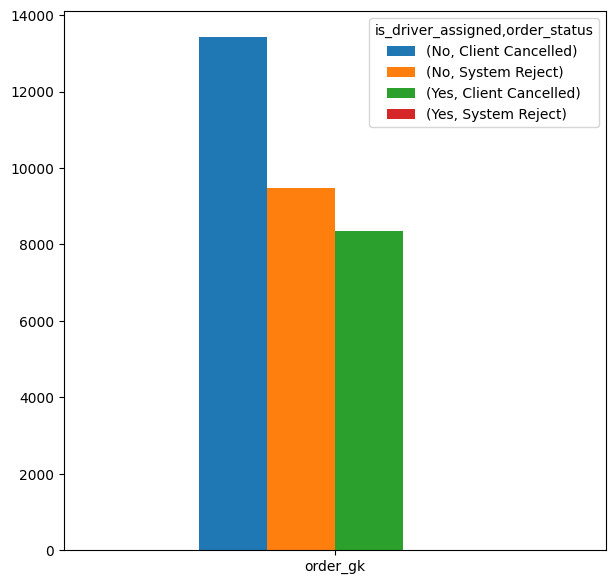

In [6]:
# a plot of these outcomes
df_piv = df.pivot_table(columns = ["is_driver_assigned", "order_status"], values = "order_gk", aggfunc = "count")
df_piv.plot(kind="bar", subplots=False, figsize=(7, 7), legend=True, rot=0)

Here, we can see that there are a large number of clients who cancelled when there was no driver assigned, likely due to waiting too long or finding another mode of transportation. Next, for the riders who have not been assigned a ride and got system rejected, it simply shows how many riders have been system rejected, as this system rejection means they should not be getting a ride in the first place. For the drivers who have been assigned but cancelled, this could also indicate clients waiting too long. Lastly, for those who have been assigned a driver and got system cancelled, this is likely due to a system error where the app may have accidentally assigned a driver to a non-eligible person. 

In [7]:
df["order_hours"] = pd.to_datetime(
    df["order_datetime"],
    format="%H:%M:%S"
).dt.hour

<Axes: title={'center': 'Count of Failed Orders by Hour of Day'}, xlabel='order_hours'>

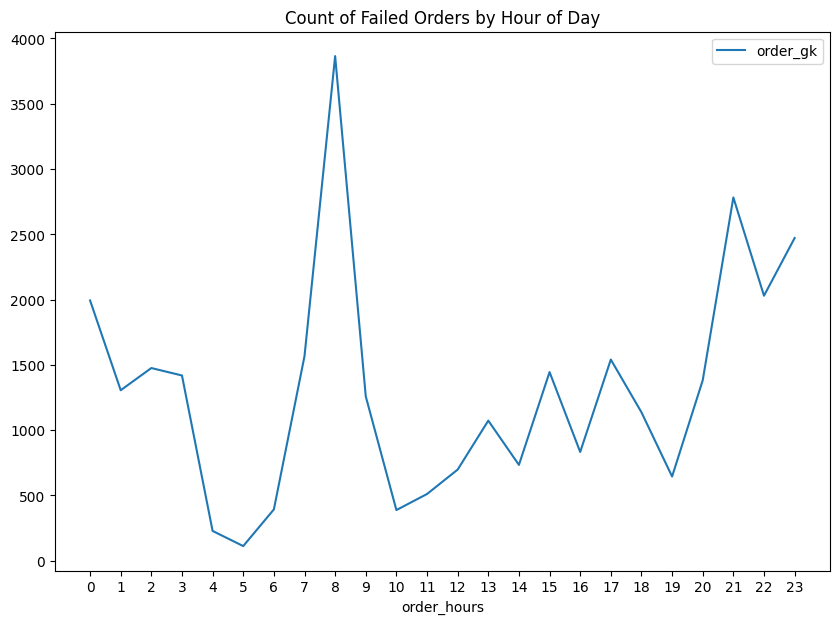

In [8]:
df.groupby(by = "order_hours")["order_gk"].count().plot(figsize=(10, 7),
                                                         legend=True,
                                                         xticks=range(0, 24),
                                                         title="Count of Failed Orders by Hour of Day")

In [9]:
grouped_hour = df.groupby(["order_hours", "is_driver_assigned", "order_status"])["order_gk"].count()
grouped_hour

order_hours  is_driver_assigned  order_status    
0            No                  Client Cancelled     957
                                 System Reject        706
             Yes                 Client Cancelled     326
                                 System Reject          4
1            No                  Client Cancelled     633
                                                     ... 
22           No                  System Reject        660
             Yes                 Client Cancelled     415
23           No                  Client Cancelled    1144
                                 System Reject        883
             Yes                 Client Cancelled     444
Name: order_gk, Length: 73, dtype: int64

<Axes: title={'center': 'Count of Failed Orders Per Hour and Category'}, xlabel='order_hours'>

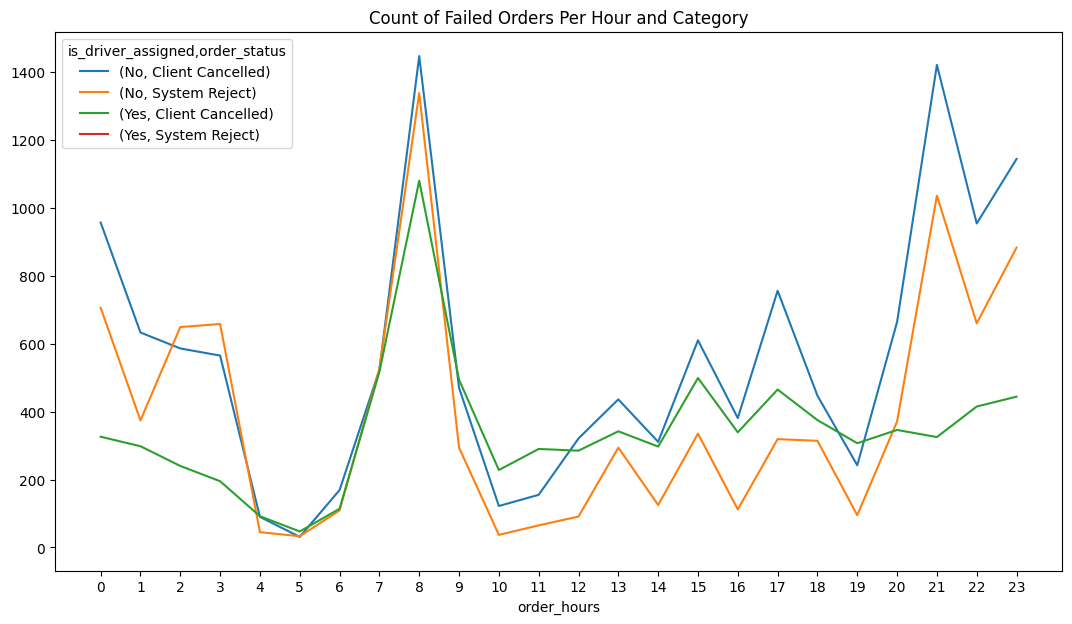

In [10]:
grouped_hour.reset_index().pivot(index="order_hours",
                                   columns=["is_driver_assigned", "order_status"],
                                   values="order_gk").plot(xticks=range(0, 24),
                                                           figsize=(13, 7),
                                                           title="Count of Failed Orders Per Hour and Category")



There is a substantially large amount of failed and cancelled orders at around 7-8 am and 9 pm. This chart's distribution mimics the one without the assigned driver and order status columns, meaning that these peaks and dips could be attributed to the volume of orders at each time rather than some kind of problem with the app. However, the possibility of an app error should not be overlooked, as the higher volume of users at the peak times could cause some strain on the app.

<Axes: title={'center': 'Average Time to Cancellation Per Hour and Driver Assignment'}, xlabel='Order Hours'>

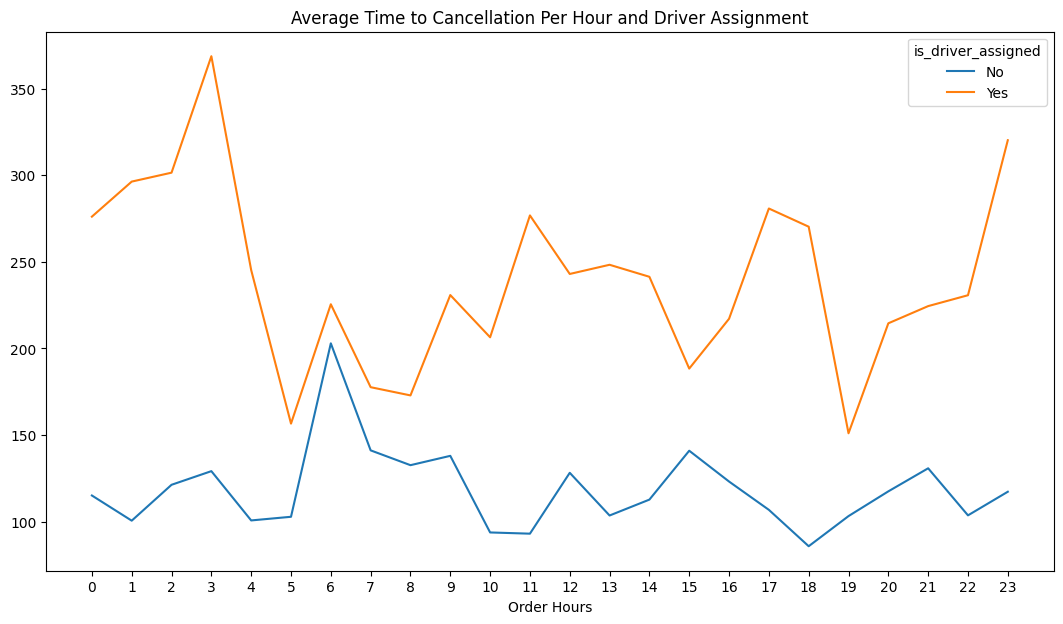

In [11]:
df_table = df.groupby(["order_hours", "is_driver_assigned"])["cancellations_time_in_seconds"].mean()
df_table.reset_index().pivot(index = "order_hours", columns = "is_driver_assigned",
                             values = "cancellations_time_in_seconds").plot(xticks=range(0, 24),
                                                                                figsize=(13, 7),
                                                                                title="Average Time to Cancellation Per Hour and Driver Assignment",
                                                                                xlabel = "Order Hours")

<Axes: title={'center': 'Average ETA per hour'}, xlabel='Order Hours'>

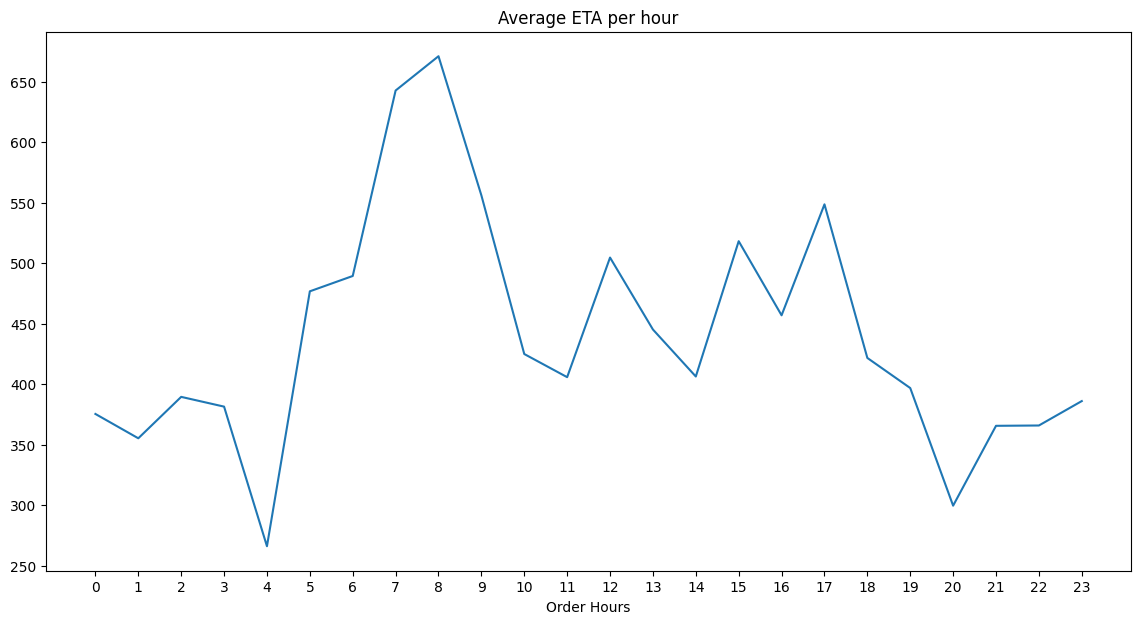

In [12]:
df.groupby("order_hours")["m_order_eta"].mean().plot(figsize=(14, 7),
                                                           xticks=range(0, 24),
                                                           title="Average ETA per hour",
                                                           xlabel = "Order Hours")

Here, the graph aligns closely with the graph of the number of failed orders. Thus, we can say here that the number of failed orders increases as the average waiting time of the orders increases. This makes sense intuitively, since a lot of people do not like waiting a long time for their order.

### Now, we are going to analyze how many hexagons encapsulate 80% of the data. This will tell us whether or not there are order-dense areas. This spatial analysis technique is very useful for delivery apps like DoorDash, Uber Eats, etc.

In [13]:
import folium
import h3

In [14]:
df["hex_id"] = df.apply(
    func=lambda row: h3.latlng_to_cell(lat=row["origin_latitude"], lng=row["origin_longitude"], res=8), axis=1)

In [15]:
df

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status,order_hours,hex_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,198.0,300050983403,Yes,Client Cancelled,18,88195d2b03fffff
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986179,No,Client Cancelled,20,88195d2b19fffff
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986174,No,Client Cancelled,20,88195d2b19fffff
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986180,No,Client Cancelled,20,88195d2b19fffff
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,46.0,300050976275,Yes,Client Cancelled,12,88195d2b1dfffff
...,...,...,...,...,...,...,...,...,...,...,...
31263,12:44:11,-0.975372,51.457846,NaN,3000597886155,43.0,300051590196,No,Client Cancelled,12,88195d2b03fffff
31264,12:42:52,-0.975372,51.457846,NaN,3000597886140,44.0,300051590176,No,Client Cancelled,12,88195d2b03fffff
31265,13:11:35,-0.975372,51.457846,NaN,3000599186906,36.0,300051648809,No,Client Cancelled,13,88195d2b03fffff
31266,13:17:21,-0.972926,51.457693,60.0,3000599187034,34.0,300051648910,Yes,Client Cancelled,13,88195d2b1dfffff


In [16]:
df_grouped = df.groupby("hex_id")["order_gk"].count()

In [17]:
df_grouped = df_grouped.reset_index().sort_values(by = "order_gk")
total_orders = df_grouped["order_gk"].sum()
df_grouped["cum_sum"] = df_grouped["order_gk"].cumsum() 
df_grouped["cum_perc"] = 100 * df_grouped["cum_sum"] / total_orders 
df_grouped[df_grouped["cum_perc"] <= 80] 

,hex_id,order_gk,cum_sum,cum_perc
11,88195d282bfffff,1,1,0.003198
38,88195d2953fffff,1,2,0.006396
122,88195d3993fffff,1,3,0.009594
79,88195d2aebfffff,1,4,0.012793
137,88195d74d5fffff,1,5,0.015991
...,...,...,...,...
61,88195d2a27fffff,1295,15628,49.980811
20,88195d284dfffff,1937,17565,56.175643
91,88195d2b19fffff,1960,19525,62.444032
87,88195d2b11fffff,2191,21716,69.451196


Here we see that 137 polygons cover roughly 77.32% of the data. This means that only 2 polygons cover the other 22.68% of the data! The other 2 polgyons must be hot spots or densely populated.

In [22]:
map = folium.Map(location=[df["origin_latitude"].mean(), df["origin_longitude"].mean()],
                 zoom_start=8.5,  # after a bit of experimentation, we thought this presents the map best
                 tiles="cartodbpositron")

In [24]:
import json
import geojson
from h3.api import basic_int as h3_api  # renamed to avoid redefinition error

def to_geojson(row):
    int_cell = int(row["hex_id"], 16)
    latlngs = h3_api.cell_to_boundary(int_cell)
    lnglats = [[lng, lat] for lat, lng in latlngs]

    geometry = {"type": "Polygon", "coordinates": [lnglats]}
    return geojson.Feature(
        id=row["hex_id"],
        geometry=geometry,
        properties={"order_gk": row["order_gk"]}
    )

geojsons = df_grouped.apply(to_geojson, axis=1).tolist()
geojson_str = json.dumps(geojson.FeatureCollection(geojsons))



In [25]:
colormap = matplotlib.colormaps["plasma"]  
max_order_gk = df_grouped["order_gk"].max()
min_order_gk = df_grouped["order_gk"].min()

In [26]:
folium.GeoJson(data=geojson_str, style_function=lambda f: {
    "fillColor": matplotlib.colors.to_hex(
        colormap((f["properties"]["order_gk"] - min_order_gk) / (max_order_gk - min_order_gk))),
    "color": "black",
    "weight": 1,
    "fillOpacity": 0.7
}).add_to(map)

In [27]:
map